In this notebook I am going to learn about BitArrays (i.e. arrays of booleans) and image indexing in general.

I am going to create an artistic representation of the original image in the following way:

1. For an input image, create an "edge map" of the edges.
2. Blur the edge map to add some thickness
3. Create a binary mask on the blurred edge map
4. Save the binary mask into a new image with a random color value

The end result will be an abstract representation of the original image, rendered with the edges at various colors.

There are a number of ways to generate edge maps, so I am going to try generating two of them:

1. Using the "Image energy", or the square of the high frequency component of the image
2. Using the gradient magnitude of the Sobel image kernel applied horizontally and vertically.

The final painting will be evocative of Andy Warhol, but only a little ;)

## Setting up, loading images, converting to Grayscale

In [356]:
using Images, FileIO, Colors;

The test image is going to be our former president, Barack Obama.

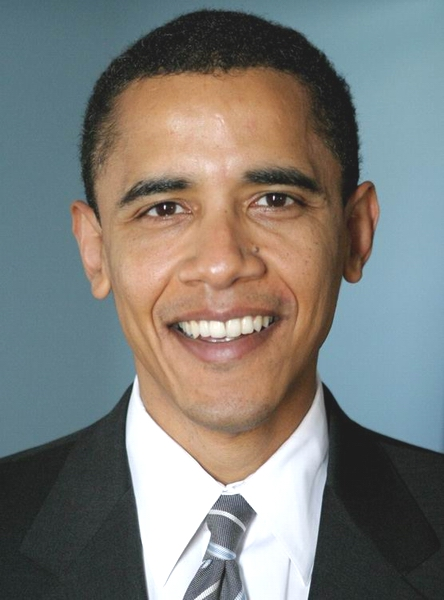

In [357]:
img = load("obama.jpg")

And it's an RGB image, as we can see:

In [358]:
typeof(img)

Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}

But I want to manipulate the grayscale image, since to compute things like image gradients (to find edges), it is easier to define on grayscale images. The same `.` casting notation can be used with the `Gray` color type.

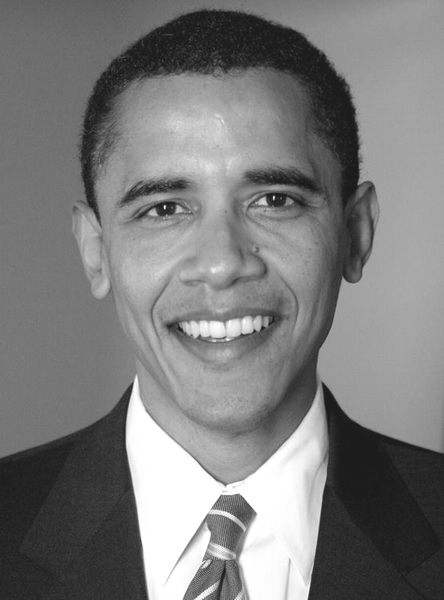

In [359]:
gray_img = Gray.(img)

And we can see the image is now of type `Gray`.

In [360]:
typeof(gray_img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

You access the gray value with `.val`, since if you just try to index an image to see its value, the actual color pixel will get rendered.

In [362]:
gray_img[1, 1].val

0.384N0f8

In [363]:
gray_img[1, 1]

Find the edges

Two ways of computing sharpness map:

```
Image gray = color2gray(im);
Image blurred_gray = gaussianBlur_seperable(gray, sigma);
Image high_freq = gray - blurred_gray;
Image sharpness_map = gaussianBlur_seperable(high_freq * high_freq, 4 * sigma);
sharpness_map = sharpness_map / sharpness_map.max();
return sharpness_map;
```

Image gradientMagnitude(const Image &im, bool clamp){
 
    // sobel filtering in x direction
    Filter sobelX(3, 3);
    sobelX(0,0) = -1.0; sobelX(1,0) = 0.0; sobelX(2,0) = 1.0;
    sobelX(0,1) = -2.0; sobelX(1,1) = 0.0; sobelX(2,1) = 2.0;
    sobelX(0,2) = -1.0; sobelX(1,2) = 0.0; sobelX(2,2) = 1.0;
 
    Image imSobelX = sobelX.Convolve(im, clamp);
 
    // sobel filtering in y direction
    Filter sobelY(3, 3);
    sobelY(0,0) = -1.0; sobelY(1,0) = -2.0; sobelY(2,0) = -1.0;
    sobelY(0,1) = 0.0; sobelY(1,1) = 0.0; sobelY(2,1) = 0.0;
    sobelY(0,2) = 1.0; sobelY(1,2) = 2.0; sobelY(2,2) = 1.0;
 
 
    Image imSobelY = sobelY.Convolve(im, clamp);
 
    // squared magnitude
    Image magnitude = imSobelX*imSobelX + imSobelY*imSobelY;
 
    // take the square root
    for(int i=0; i<magnitude.number_of_elements(); i++ ){
        magnitude(i) = sqrt(magnitude(i));
    }
 
    return magnitude;
 
}

In [7]:
?reduce

search: reduce reducedim mapreduce mapreducedim



```
reduce(op, v0, itr)
```

Reduce the given collection `ìtr` with the given binary operator `op`. `v0` must be a neutral element for `op` that will be returned for empty collections. It is unspecified whether `v0` is used for non-empty collections.

Reductions for certain commonly-used operators have special implementations which should be used instead: `maximum(itr)`, `minimum(itr)`, `sum(itr)`, `prod(itr)`, `any(itr)`, `all(itr)`.

The associativity of the reduction is implementation dependent. This means that you can't use non-associative operations like `-` because it is undefined whether `reduce(-,[1,2,3])` should be evaluated as `(1-2)-3` or `1-(2-3)`. Use `foldl` or `foldr` instead for guaranteed left or right associativity.

Some operations accumulate error, and parallelism will also be easier if the reduction can be executed in groups. Future versions of Julia might change the algorithm. Note that the elements are not reordered if you use an ordered collection.

```
reduce(op, itr)
```

Like `reduce(op, v0, itr)`. This cannot be used with empty collections, except for some special cases (e.g. when `op` is one of `+`, `*`, `max`, `min`, `&`, `|`) when Julia can determine the neutral element of `op`.


In [8]:
reduce(max, [x.val for x in high_energy])

LoadError: UndefVarError: high_energy not defined

In [9]:
reduce(min, [x.val for x in high_energy])

LoadError: UndefVarError: high_energy not defined

In [10]:
?imfilter

search: imfilter imfilter! imfilter_fft imfilter_LoG imfilter_gaussian



```
imfilter([T], img, kernel, [border="replicate"], [alg]) --> imgfilt
imfilter([r], img, kernel, [border="replicate"], [alg]) --> imgfilt
imfilter(r, T, img, kernel, [border="replicate"], [alg]) --> imgfilt
```

Filter an array `img` with kernel `kernel` by computing their correlation.

`kernel[0,0,..]` corresponds to the origin (zero displacement) of the kernel; you can use `centered` to place the origin at the array center, or use the OffsetArrays package to set `kernel`'s indices manually. For example, to filter with a random *centered* 3x3 kernel, you could use either of the following:

```
kernel = centered(rand(3,3))
kernel = OffsetArray(rand(3,3), -1:1, -1:1)
```

`kernel` can be specified as an array or as a "factored kernel," a tuple `(filt1, filt2, ...)` of filters to apply along each axis of the image. In cases where you know your kernel is separable, this format can speed processing.  Each of these should have the same dimensionality as the image itself, and be shaped in a manner that indicates the filtering axis, e.g., a 3x1 filter for filtering the first dimension and a 1x3 filter for filtering the second dimension. In two dimensions, any kernel passed as a single matrix is checked for separability; if you want to eliminate that check, pass the kernel as a single-element tuple, `(kernel,)`.

Optionally specify the `border`, as one of `Fill(value)`, `"replicate"`, `"circular"`, `"symmetric"`, `"reflect"`, `NA()`, or `Inner()`. The default is `"replicate"`. These choices specify the boundary conditions, and therefore affect the result at the edges of the image. See `padarray` for more information.

`alg` allows you to choose the particular algorithm: `FIR()` (finite impulse response, aka traditional digital filtering) or `FFT()` (Fourier-based filtering). If no choice is specified, one will be chosen based on the size of the image and kernel in a way that strives to deliver good performance. Alternatively you can use a custom filter type, like `KernelFactors.IIRGaussian`.

Optionally, you can control the element type of the output image by passing in a type `T` as the first argument.

You can also dispatch to different implementations by passing in a resource `r` as defined by the ComputationalResources package.  For example,

```
imfilter(ArrayFire(), img, kernel)
```

would request that the computation be performed on the GPU using the ArrayFire libraries.

See also: [`imfilter!`](@ref), [`centered`](@ref), [`padarray`](@ref), [`Pad`](@ref), [`Fill`](@ref), [`Inner`](@ref), [`KernelFactors.IIRGaussian`](@ref).


In [11]:
typeof(img[1])

ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}

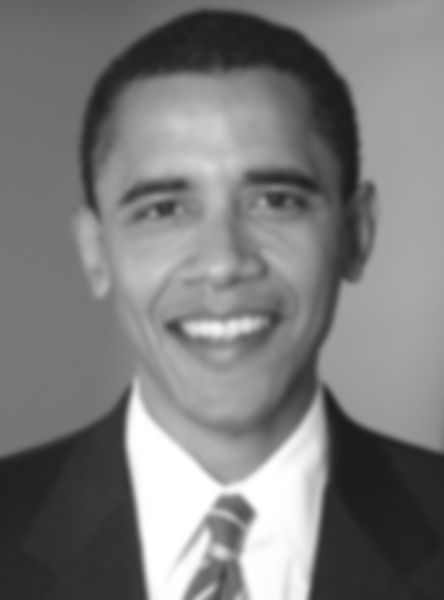

In [22]:
σ = 3;
img_blurred = imfilter(gray_img, Kernel.gaussian(σ))

** is in Python, and you get a "syntax: use "^" instead of "**"" error if you use it =)

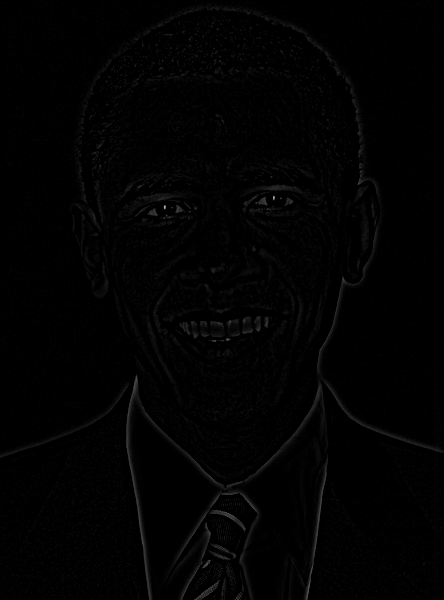

In [36]:
high_freq = gray_img - img_blurred

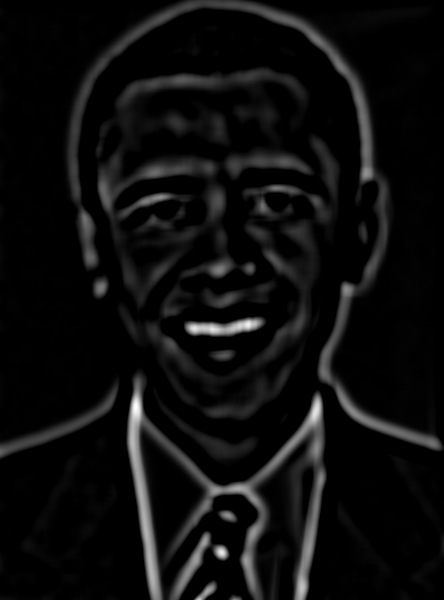

In [53]:
image_sharpness = imfilter(high_freq .^ 1, Kernel.gaussian(2 * σ));
# normalize sharpness map
image_sharpness ./= maximum(image_sharpness)

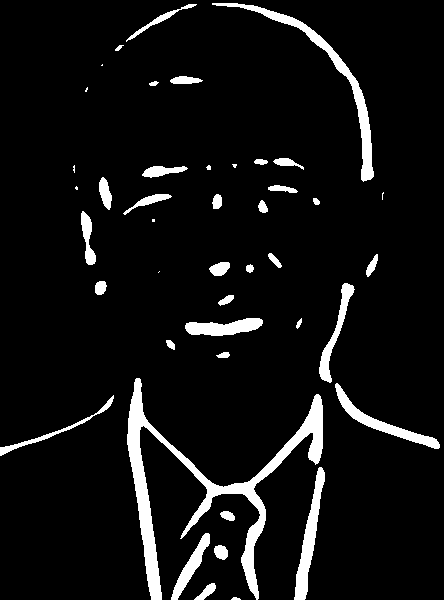

In [116]:
threshed = RGB.(Gray.(image_sharpness .> 0.25))

In [133]:
painting = zeros(threshed);

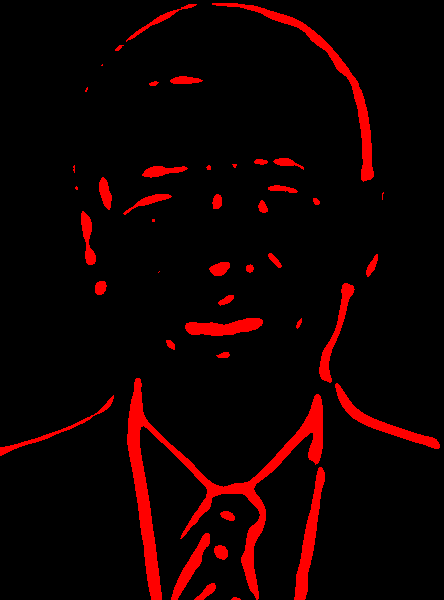

In [134]:
painting[threshed .== RGB(1, 1, 1)] = RGB(1, 0, 0);
painting

In [135]:
size(threshed)

(600,444)

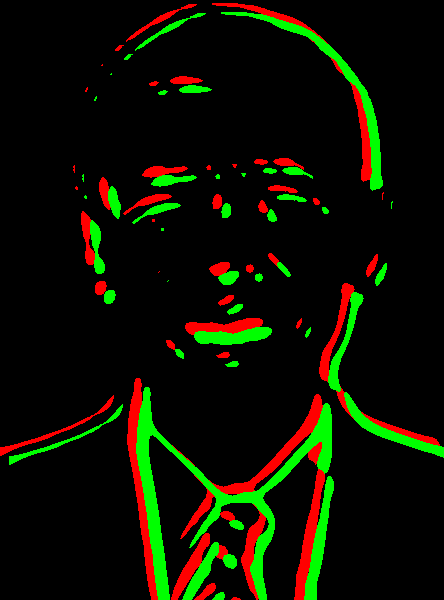

In [136]:
n = fill(false, size(threshed));
start_x = 10;
start_y = 10;
n[start_x:end, start_y:end] = (threshed .== RGB(1, 1, 1))[1:end-start_x+1, 1:end-start_y+1];
painting[n] = RGB(0, 1, 0);
painting

Painting algorithm:

1. Generate a thresholded mask at some randomly-selected value of sigma
2. Randomly pick a subimage height and width
3. Randomly pick a color
4. Randomly pick a starting position in the image
5. Put it into the original painting

The entire input to the collection is how many iterations of the above steps we want to do

In [229]:
function sharpness_map(img, σ, thresh)
    g = Gray.(img);
    high_freq = g - imfilter(g, Kernel.gaussian(σ));
    sharpness_map = imfilter(high_freq .^ 2, Kernel.gaussian(2 * σ));
    # normalize sharpness map
    sharpness_map ./ reduce(max, [x.val for x in sharpness_map]);
    threshed = image_sharpness .> thresh;
end

sharpness_map (generic function with 2 methods)

Julia 0.5 documentation for random numbers: http://docs.julialang.org/en/release-0.5/stdlib/numbers/#random-numbers

In [230]:
function painting_map(s_map)
    size_x, size_y = size(s_map);
    n = fill(false, (size_x, size_y));
    x_start = rand(1:size_x);
    y_start = rand(1:size_y);
    x_end = rand(x_start:size_x);
    y_end = rand(y_start:size_y);
    n[x_start:x_end, y_start:y_end] = s_map[x_start:x_end, y_start:y_end];
    return n;
end

painting_map (generic function with 1 method)

In [299]:
reference = load("obama.jpg");
size_x = size(reference, 1);
size_y = size(reference, 2);

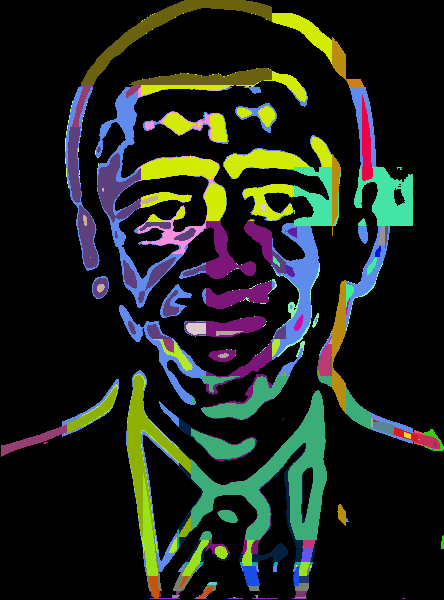

In [301]:
painting = zeros(reference);
for i in 1:100
    s_map = sharpness_map(reference, 2 * rand() + 0.5, rand() / 2);
    n = painting_map(s_map);
    painting[n] = rand(RGB);
end
painting

In [339]:
function compute_dst_range(offset, max_val)
    if offset > 0
        return offset+1:max_val;
    else
        return 1:max_val+offset;
    end
end

compute_dst_range (generic function with 1 method)

In [340]:
function compute_src_range(offset, max_val)
    return 1:max_val-abs(offset);
end

compute_src_range (generic function with 1 method)

In [348]:
function painting_map_offset(s_map)
    size_x, size_y = size(s_map);
    n = fill(false, (size_x, size_y));
    multiplier = 10;
    x_start = Int(round(rand(-1*size_x / multiplier:size_x / multiplier)));
    y_start = Int(round(rand(-1*size_y / multiplier:size_y / multiplier)));
    n[compute_dst_range(x_start, size_x),
      compute_dst_range(y_start, size_y)] = 
        s_map[compute_src_range(x_start, size_x),
              compute_src_range(y_start, size_y)];
    return n;
end

painting_map_offset (generic function with 1 method)

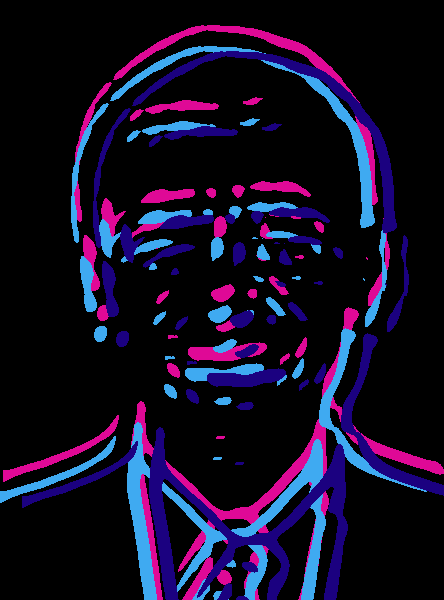

In [355]:
painting = zeros(reference);
for i in 1:3
    s_map = sharpness_map(reference, 1.5, 0.2);
    n = painting_map_offset(s_map);
    painting[n] = rand(RGB);
end
painting